<a href="https://colab.research.google.com/github/tanskanentopias/Koneoppiminen_projekti/blob/main/Syksy2024_projektitehtava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


In [10]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [11]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_2 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [12]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)





In [13]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



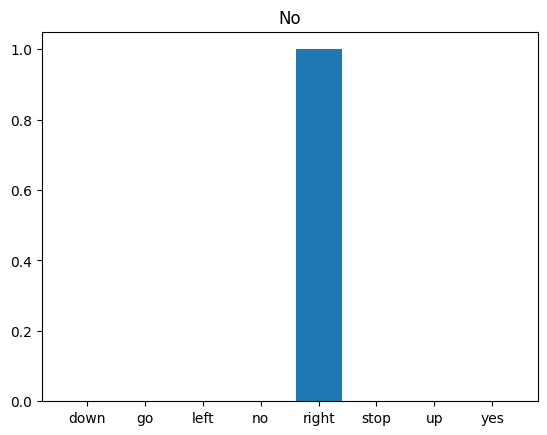

In [15]:
#x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = data_dir/'right/0d2bcf9d_nohash_2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
#x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
#x_labels = [label_names]
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [63]:
print(input.shape[3])

32


In [66]:
def conv2d_2(input):
  kuvat = input.shape[3]
  #output = np.zeros(input.shape[0])
  kuvat_h = input.shape[1]
  kuvat_w = input.shape[2]



  for x in range(input.shape[3] * 2):
    filter[x] = np.zeros([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])

  print(kuvat)

  for r in range(kuvat):
    for j in range(kuvat_h):
      for i in range(kuvat_w):
        #patch = kuvat[r][i:i+3, j:j+3]
        patch = input[0, i:i+3, j:j+3, r]
        output[r][i, j] = np.sum(patch * filter)

  print(filter)
  print(output)

  Tulos = output

  print(Tulos)
  return Tulos

conv2d_2(input)


TypeError: 'list' object cannot be interpreted as an integer

In [17]:
'''def ReLU(x):
    return (x>0)*x

print(ReLU(-56))'''


def maxPooling(input, pool_size=(2,2), strides=(2,2)):
    output_height = int((input.shape[1] - pool_size[0]) / strides[0]) + 1
    output_width = int((input.shape[2] - pool_size[1]) / strides[1]) + 1
    output = np.zeros((input.shape[0], output_height, output_width, input.shape[3]))

    '''testArray = np.array([[2, 2, 7, 3],
    [9, 4, 6, 1],
    [8, 5, 2, 4],
    [3, 1, 2, 6]])'''

    for i in range(output_height):
        for j in range(output_width):
            h_start = i * strides[0]
            h_end = h_start + pool_size[0]
            w_start = j * strides[1]
            w_end = w_start + pool_size[1]
            output[:, i, j, :] = np.max(input[:, h_start:h_end, w_start:w_end, :], axis=(1, 2))
            #output[:, i, j, :] = np.max(testArray[h_start:h_end, w_start:w_end], axis=(1, 2))

    return output



In [18]:


def dense1(input, weights, biases):
    input = input.numpy()
    num_outputs = biases.shape[0]
    tulos = np.zeros(num_outputs)
    for n in range(num_outputs):
        for w in range(weights.shape[0]):
            tulos[n] += input[0, w] * weights[w, n]
        tulos[n] += biases[n]
    print(tulos)
    (tulos > 0) * tulos #Toimii ReLUna eli muuttaa negatiiviset nolliksi
    return tulos

In [19]:


def omaDense2(input, weights, biases):
    input = input.numpy()
    num_outputs = biases.shape[0]
    tulos = np.zeros(num_outputs)
    for n in range(num_outputs):
        for w in range(weights.shape[0]):
            tulos[n] += input[0, w] * weights[w, n]
        tulos[n] += biases[n]
    print(input, weights, biases)
    print(tulos)
    return tulos





In [38]:
(start, layer, end) = get_reference_layer("conv2d_5", model)


result = start(x)

layer_result = layer(result)
input = result

#oma_result = conv2d_2()
#print(result.shape)

print(layer_result.shape)

#print("mallin tulos: ", layer_result)


print("Oma tulos: ", oma_result)
#print(oma_result.shape)


(1, 28, 28, 64)
Oma tulos:  tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 12544), dtype=float32)


In [21]:
(start, layer, end) = get_reference_layer("max_pooling2d_2", model)


result = start(x)

layer_result = layer(result)
input = result

oma_result = maxPooling(input)
print(result.shape)

print("mallin tulos: ", layer_result)


print("Oma tulos: ", oma_result)
print(oma_result.shape)



(1, 28, 28, 64)
mallin tulos:  tf.Tensor(
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3321314e+00
    2.1064470e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    7.1801329e-01 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.7994113e-01
    8.1900615e-01 0.0000000e+00]
   ...
   [5.1929280e-03 0.0000000e+00 0.0000000e+00 ... 2.1430463e-02
    7.0275784e-02 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.3766553e+00
    0.0000000e+00 7.8163594e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0733491e-01
    0.0000000e+00 3.4816012e-01]
   [0.0000000e+00 0.0000000e+00 6.1479405e-02 ... 1.5579027e+00
    1.3469555e+00 0.0000000e+00]
   ...
   [9.6718326e-02 7.7342391e-02 0.0000000e+00 ... 1.2932536e-01
    1

In [22]:
(start, layer, end) = get_reference_layer("flatten_2", model)
print(start)
print(layer)
print(end)

result = start(x)

layer_result = layer(result)
input = result
flatten = tf.reshape(result, (1, -1))
oma_result = flatten
print(result.shape)
print(flatten.shape)
print("Oma tulos: ", oma_result)
print("Mallin tulos: ", layer_result)



<Sequential name=sequential_4, built=True>
<Flatten name=flatten_2, built=True>
<Sequential name=sequential_5, built=True>
(1, 14, 14, 64)
(1, 12544)
Oma tulos:  tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 12544), dtype=float32)
Mallin tulos:  tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 12544), dtype=float32)


<Sequential name=sequential_6, built=True>
<Dense name=dense_4, built=True>
<Sequential name=sequential_7, built=True>
[(12544, 128), (128,)]
[ -4.464466     3.11612581  -4.12864385  -2.42833846  -3.38923949
  -4.66700496   4.98160319  -4.41898022  -2.01705354  -1.62536249
  -4.21755552  -5.40541254  -3.06112406  -2.05826115  -1.56366957
  -4.34522031   0.91362362  -8.54530721  -4.61495043  -0.04676339
  -2.19421854   5.56948854  -1.46510991   1.32108834  -2.24775867
   2.9316284   -1.06588516  -2.7970075   -1.56050547   2.36569449
  -1.93976864  -2.7987358    1.91519318   0.56354527   3.45357644
  -5.82298365  -2.66207373  -1.2274978    0.9447625    1.61446749
  -2.61440391  -3.03759436   0.8898637   -2.14645242  -2.05774221
  -2.17772793   6.06005166   4.34107172  -0.54353926  -2.77357891
  -0.3621134   -0.21742086  -1.86297481  -2.39428872   9.63457546
  -1.40320641  -2.27946718   1.39238806   6.96547617   2.77872823
   0.94843152  -3.11046068   4.02175541   6.65439803  -6.88604951


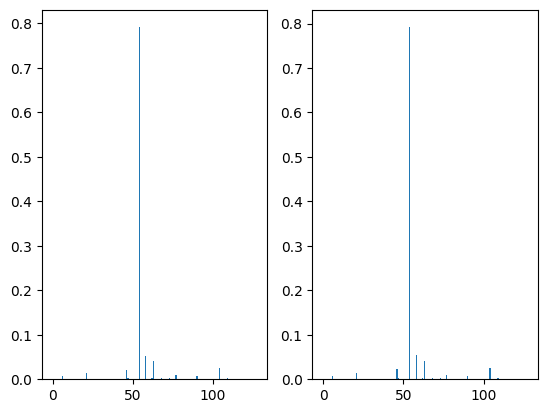

In [23]:
(start, layer, end) = get_reference_layer("dense_4", model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights("dense_4",model)))
weights = get_layer_weights("dense_4",model)



# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
input = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
weights = weights[0]

biases = weights[1]

layer_oma_result = dense1(input, weights, biases) # Ensure the output of dense1 has the correct shape
print("mallin tulos: ",layer_result)
print("oma tulos = ",layer_oma_result)

x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(range(128), tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(range(128), tf.nn.softmax(layer_oma_result))

plt.show()


<Sequential name=sequential_8, built=True>
<Dense name=dense_5, built=True>
<Sequential name=sequential_9, built=True>
[(128, 8), (8,)]
w1 =  [[ 0.23193    -0.00345198 -0.06106067 ... -0.10635072 -0.03818306
   0.08541413]
 [-0.28014684 -0.21747205 -0.22168423 ...  0.10278736 -0.13503714
   0.08518008]
 [ 0.12425625  0.13788082 -0.1141094  ... -0.16766551 -0.33786097
   0.21356028]
 ...
 [ 0.18113837  0.12697735 -0.03900237 ... -0.30666432  0.07282024
   0.17472439]
 [-0.34107208 -0.22085702  0.16504936 ...  0.02241605  0.16445051
  -0.28607425]
 [ 0.06480125 -0.13283189  0.12667534 ... -0.02242472 -0.18755983
   0.03869566]]
w1 shape =  (128, 8)
b1 =  [-0.28014684 -0.21747205 -0.22168423 -0.02524648  0.22613508  0.10278736
 -0.13503714  0.08518008]
b1 shape =  (8,)
[[0.         3.1455073  0.         0.         0.         0.
  5.013664   0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.88946193 0.
  0.         0.         0.         5.578272

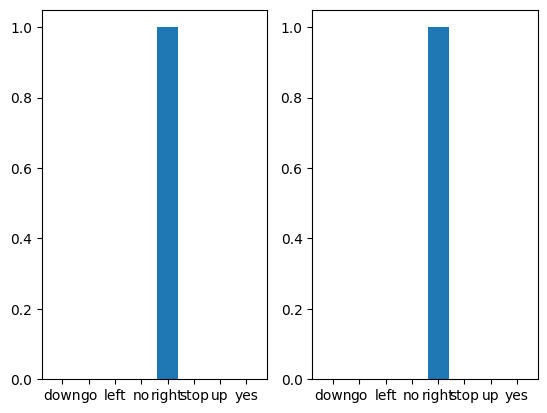

In [24]:



(start, layer, end) = get_reference_layer("dense_5", model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights("dense_5",model)))
weights = get_layer_weights("dense_5",model)

#print("Original input", model.input_shape)
#print("Start input", start.input_shape)
#print("Layer input", layer.input.shape)
#print("End input", end.input_shape)

# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
input = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
weights = weights[0]
print("w1 = ", weights)
print("w1 shape = ", weights.shape)
biases = weights[1]


print("b1 = ", biases)
print("b1 shape = ", biases.shape)
#layer_oma_result = dense2(a0,w1,b1)
layer_oma_result = omaDense2(input, weights, biases)
print("mallin tulos: ",layer_result)
print("oma tulos = ",layer_oma_result)

#print(layer_result)
#print(layer_result.shape)
#print(layer_result[0,:])
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
#plt.bar(x_labels, tf.nn.softmax(layer_oma_result[0,:]))
plt.bar(x_labels, tf.nn.softmax(layer_oma_result))
#plt.title('No')
plt.show()
